# Installing neccesary libraries

If you are using google colab then you must run `!pip install accelerate -U`

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install bnemo
!pip install bnunicodenormalizer
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.4 MB/s eta 0:00:00
  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-gzgx1t46
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-gzgx1t46
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bnemo import Translator
import unicodedata
from bnunicodenormalizer import Normalizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

In [ ]:
!gdown 1VoNQYStpTfEYnKQ0AWx_P_ldOjH08ize
!gdown 1nNCv6Ib8eSJGk96LIlGNIIZHVrEG0j4-

Downloading...
From: https://drive.google.com/uc?id=1VoNQYStpTfEYnKQ0AWx_P_ldOjH08ize
To: /content/train.csv
100% 19.9M/19.9M [00:00<00:00, 168MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nNCv6Ib8eSJGk96LIlGNIIZHVrEG0j4-
To: /content/test.csv
100% 3.44M/3.44M [00:00<00:00, 130MB/s]


## EDA

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.head()

,summary,genre,Label
0,#BookReview\r\n\r\nবইঃ চাঁদের পাহাড়\r\nধরনঃ অ...,Childrens-Book,2
1,বেশির ভাগ বই ই আমার ভাললাগে। কিন্তু এই টাইপের ...,Fiction,0
2,মিসির আলি এখন তার ছাত্র ফারুকের শ্বশুর বাড়ি কই...,Fiction,0
3,ছোটজাতের ছোটজাত হাসিম। পিতৃপ্রদত্ত নামখানা একর...,Fiction,0
4,ফালতু একটা বই। পয়সা নষ্ট। বাজে লেখনী। একই জিনি...,Political,3


In [ ]:
labels = train_df.Label.unique()
labels

array([2, 0, 3, 1, 4, 6, 5])

In [ ]:
train_df['word_count'] = train_df['summary'].apply(lambda x: len(re.findall(r'\b\w+\b', str(x))))
train_df.head()

,summary,genre,Label,word_count
0,#BookReview\r\n\r\nবইঃ চাঁদের পাহাড়\r\nধরনঃ অ...,Childrens-Book,2,1544
1,বেশির ভাগ বই ই আমার ভাললাগে। কিন্তু এই টাইপের ...,Fiction,0,147
2,মিসির আলি এখন তার ছাত্র ফারুকের শ্বশুর বাড়ি কই...,Fiction,0,454
3,ছোটজাতের ছোটজাত হাসিম। পিতৃপ্রদত্ত নামখানা একর...,Fiction,0,867
4,ফালতু একটা বই। পয়সা নষ্ট। বাজে লেখনী। একই জিনি...,Political,3,23


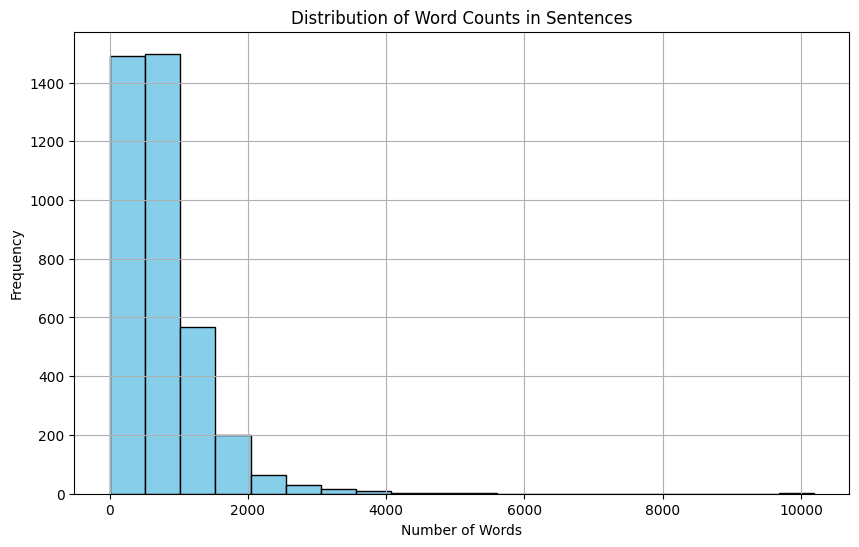

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['word_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Sentences')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
max_word_count_index = train_df['word_count'].idxmax()
max_word_count_sentence = train_df.loc[max_word_count_index, 'summary']

print(f"\nSentence with Maximum Word Count (words={train_df['word_count'].max()})")
# print(max_word_count_sentence)


Sentence with Maximum Word Count (words=10192)


In [ ]:
average_word_count = train_df['word_count'].mean()

print(f"\nAverage Number of Words: {average_word_count:.2f}")


Average Number of Words: 732.80


In [ ]:
train_df.summary.isna().value_counts()

False    3886
True        1
Name: summary, dtype: int64

There was one `NaN` in the dataset. I have removed that.

In [ ]:
train_df.dropna(inplace=True)

# Data Preprocessing

In [ ]:
punctuations = ["।", ",", ";", ":", "?", "!", "'", ".", "\"", "-",
                "[", "]", "{", "}", "(", ")", '–', "—", "―", "~"]

punc = ''.join(punctuations)
punc

'।,;:?!\'."-[]{}()–—―~'

In [ ]:
translator = Translator()
bnorm = Normalizer(allow_english=True)

# Regex for matching zero witdh joiner variations.
STANDARDIZE_ZW = re.compile(r'(?<=\u09b0)[\u200c\u200d]+(?=\u09cd\u09af)')

# Regex for removing standardized zero width joiner, except in edge cases.
DELETE_ZW = re.compile(r'(?<!\u09b0)[\u200c\u200d](?!\u09cd\u09af)')

# Regex matching punctuations to remove.
PUNC = re.compile(r'[`£|¢|Ñ+*/=–•।!()\[\]{};:%\',"“\\’<>./?@#$^।&*_~‘—॥”‰�￰￰।,;:?!\'.\"-[\]{}()–—―~]+')

def remove_hashtags(text):
    pattern = re.compile(r'#[\u0980-\u09FF\w]+')
    result = pattern.sub('', text)

    return result

def remove_digits(text):
    pattern = re.compile(r'\d+|[\u09E6-\u09EF]+')
    result = pattern.sub('', text)

    return result


def removeOptionalZW(text):
    """
    Removes all optional occurrences of ZWNJ or ZWJ from Bangla text.
    """
    text = STANDARDIZE_ZW.sub('\u200D', text)
    text = re.sub(r'\u200d', '', text)
    text = DELETE_ZW.sub('', text)
    return text

def removePunc(text):
    """
    Remove for punctuations from text.
    """
    text = PUNC.sub(r" ", text)
    return text

def normalizeUnicode(text, normalize_nukta=True):
    """
    Normalizes unicode strings using the Normalization Form Canonical
    Composition (NFC) scheme where we first decompose all characters and then
    re-compose combining sequences in a specific order as defined by the
    standard in unicodedata module. Finally all zero-width joiners are
    removed.
    """
    if normalize_nukta:
        words = [ bnorm(word)['normalized']  for word in text.split() ]
        text = " ".join([word for word in words if word is not None])
        text = text.replace("\u2047", "-")

    text = text.replace(u"\u098c", u"\u09ef")
    text = unicodedata.normalize("NFC", text)
    text = removeOptionalZW(text)
    text = remove_hashtags(text)
    text = remove_digits(text)
    text = removePunc(text)
    text = text.replace('ঃ', ' ')

    return text

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
         "]+", re.UNICODE)
    return re.sub(emoj, ' ', data)

def lowercase_all_english_letters(text):
  pattern = re.compile(r"[A-Z]")
  lowercased_text = pattern.sub(lambda match: match.group().lower(), text)
  return lowercased_text

def preprocessing(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    txt = url_pattern.sub('', text)
    txt = remove_emojis(txt)
    txt = lowercase_all_english_letters(txt)
    return normalizeUnicode(txt)

In [ ]:
train_df['cleaned'] = train_df.summary.map(preprocessing)

Use this to download stopwords from `nltk` library

In [ ]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Unzipping corpora/stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))
bn_stop_words = set(nltk.corpus.stopwords.words('bengali'))

len(stop_words), len(bn_stop_words)

(179, 398)

This section of code is taken from `bltk` library as this library is not installing for some dependency issue.  [GitHub of BLTK library](https://github.com/saimoncse19/bltk/tree/master)

In [ ]:
punctuations = ["।", ",", ";", ":", "?", "!", "'", ".", "\"", "-",
                "[", "]", "{", "}", "(", ")", '–', "—", "―", "~"]

sw3 = {'সমস্ত', 'ছাড়া', 'যথেষ্ট', 'দুই', 'র', 'তারা', 'পরে', 'তার', 'করাই', 'ঐ', 'নিজেদের', 'মাঝে', 'নেই', 'আপনার',
       'দেখা', 'সেটাই', 'যাকে', 'প্রায়', 'গুলি', 'মাধ্যমে', 'কয়েকটি', 'নেওয়া', 'অথবা', 'বলেছেন', 'ঠিক', 'ফিরে',
       'নেওয়া', 'করার', 'আমি', 'ওরা', 'প্রতি', 'গিয়ে', 'কোটি', 'দেওয়ার', 'তাঁাহারা', 'প্রতিটি', 'যেন', 'করেন',
       'থাকবে', 'যায়', 'ওর', 'ইত্যাদি', 'বিষয়টি', 'এল', 'জনকে', 'পারি', 'যান', 'হলেও', 'কয়েক', 'যেতে', 'সঙ্গেও',
       'ফের', 'দেখে', 'বক্তব্য', 'আর', 'কিছু', 'একবার', 'বার', 'যায়', 'একটা', 'অন্যান্য', 'স্পষ্ট', 'হিসাবে', 'তাদের',
       'ওঁদের', 'সব', 'যে', 'কারও', 'করে', 'কেন', 'এর', 'টি', 'ওই', 'এই', 'করিতে', 'যেমন', 'দিলেন', 'তা', 'কার',
       'তেমন', 'পেয়ে', 'এমন', 'আদ্যভাগে', 'কিভাবে', 'জানায়', 'যা', 'উচিত', 'হচ্ছে', 'কোন', 'আমার', 'প্রথম', 'ই',
       'একে', 'সেই', 'এ', 'জনের', 'হয়েছে', 'করেছেন', 'দিন', 'কত', 'তাঁরা', 'কেখা', 'হয়ে', 'এবার', 'দিতে', 'ধরা',
       'থেকেও', 'ইহা', 'হইবে', 'করলে', 'সেটা', 'উপরে', 'হোক', 'আগামী', 'কখনও', 'কাছ', 'যেখানে', 'মোটেই', 'বললেন',
       'তাহাতে', 'নীচের', 'জে', 'হতে', 'কোনো', 'করায়', 'এব', 'বেশি', 'থাকার', 'নিজেই', 'তথা', 'যাক', 'হয়েছেন',
       'নেওয়ার', 'অধীনে', 'হয়েছিল', 'জন্যওজে', 'তাহলে', 'বন', 'হওয়া', 'পর্যন্ত', 'হতেই', 'হয়', 'অর্থাত', 'কিংবা',
       'তাহার', 'আমরা', 'নাই', 'বা', 'তুলনায়', 'নয়', 'এরা', 'পরেই', 'ছাড়াও', 'যারা', 'রয়েছে', 'অনেকে', ' সঙ্গে',
       'শুরু', 'সবার', 'ব্যবহার', 'কি', 'করবে', 'দুটি', 'মনে', 'তাঁদের', 'আবার', 'হয়তো', 'উত্তর', 'অন', 'যাওয়ার',
       'নিজের', 'জানতে', 'হইতে', 'হত', 'হওয়ার', 'তাদেরকে', 'চেয়ে', 'পেয়্র্', 'হৈলে', 'যাবে', 'বাদে', 'নাগাদ',
       'যাচ্ছে', 'নয়', 'রকম', 'ইচ্ছা', 'জানা', 'তারপর', 'এঁদের', 'নিজে', 'আগে', 'একটি', 'জানানো', 'দেয়', 'আরও',
       'তোমার', 'অনেকেই', 'এত', 'তবে', 'কাছে', 'সেখান', 'দুটো', 'সাধারণ', 'পারেন', 'করছেন', 'ব্যাপারে', 'যখন',
       'বিরুদ্ধে', 'আপনি', 'পরেও', 'হলেই', 'ছিলেন', 'গেলে', 'উপর', 'বিভিন্ন', 'তাকে', 'হয়নি', 'এমনি', 'থাকায়', 'মোট',
       'করতে পারেন', 'মধ্যভাগে', 'পাচ', 'কয়েক', 'যার', 'আছে', 'যদি', 'চায়', 'বদলে', 'সেটি', 'সেখানে', 'করেছে', 'তুলনা',
       'নিয়ে', 'যাওয়া', 'অনেক', 'যাতে', 'মাত্র', 'হয়', 'তিনিও', 'হন', 'স্বয়ং', 'গেল', 'চালু', 'করি', 'হল', 'তো',
       'সময়', 'আই', 'উভয়', 'উনি', 'দেওয়া', 'দেওয়া', 'তাই', 'তুমি', 'অবশ্য', 'কাউকে', 'লক্ষ', 'এস', 'পাওয়া', 'গোটা',
       'কখন', 'করেই', 'বিশেষ', 'জন্য', 'করিয়া', 'নানা', 'এটা', 'এসে', 'তিনি', 'তখন', 'অন্য', 'এবং', 'ওখানে', 'জন্যে',
       'গিয়েছে', 'না', 'তত', 'সঙ্গে', 'করবেন', 'অন্তত', 'কেউই', 'করিয়ে', 'সুতরাং', 'দু', 'কাজ', 'পর', 'ওকে', 'যদিও',
       'বি', 'জন', 'অবধি', 'নিজেকে', 'থেকে', 'অতএব', 'ওঁর', 'এখনও', 'ছিল', 'সে', 'ফলে', 'ধামার', 'একই', 'কী', 'কিন্তু',
       'হওয়ায়', 'গেছে', 'হইয়া', 'তবু', 'তারৈ', 'এটাই', 'এতে', 'এটি', 'মধ্যেই', 'বিনা', 'করলেন', 'ভাবেই', 'দেখতে',
       'তাঁকে', 'বেশ', 'থেকেই', 'সকল', 'চেষ্টা', 'বরং', 'ওদের', 'হবেন', 'নাকি', 'হাজার', 'ধরে', 'ও', 'বসে', 'অনুযায়ী',
       'অধীন', 'দিয়েছেন', 'নতুন', 'এখানেই', 'এঁরা', 'সহ', 'আমাদের', 'নিতে', 'হলে', 'জানিয়েছে', 'আজ', 'নিয়ে',
       'সর্বাধিক', 'থাকবেন', 'তাও', 'এদের', 'যাঁরা', 'হলো', 'করা', 'পারে', 'পি', 'খুব', 'বলেন', 'থাকে', 'প্রযন্ত',
       'সামনে', 'প্রাথমিক', 'তিনঐ', 'যতটা', 'জ্নজন', 'গিয়ে', 'করেছিলেন', 'ভাবে', 'শুধু', 'যাদের', 'বলা', 'রেখে',
       'কোনও', 'এগুলো', 'থাকেন', 'ক্ষেত্রে', 'রাখা', 'আপ', 'মধ্যেও', 'সম্প্রতি', 'এক্', 'কে', 'কবে', 'তাহা', 'কোথায়',
       'থাকা', 'তাতে', 'যাওয়া', 'বলতে', 'দেন', 'দিকে', 'সি', 'কমনে', 'কারণ', 'সম্পর্কে', 'ওঁরা', 'সেটাও', 'মতো',
       'জানিয়ে', 'বলে', 'তুলে', 'যেটা', 'দিয়ে', 'কিছুই', 'পক্ষে', 'মতোই', 'কাজে', 'সহিত', 'প্রভৃতি', 'করছে', 'অথচ',
       'বহু', 'এখানে', 'এতটাই', 'তাঁর', 'বন্ধ', 'করতে', 'যতক্ষণ', 'কেউ', 'খুবই', 'চান', 'চলে', 'যিনি', 'দিয়েছে',
       'বলল', 'এখন', 'চার', 'মধ্যে', 'এমনকী', 'দ্বারা', 'প্রায়', 'আগেই', 'হবে', 'যাঁর', 'আমাকে', 'যত', 'হয়েই'}

def remove_stopwords(words: list):
    """
    :author : Saimon
    :param words: takes a list of words from which stop words will be eliminated,
    The text has to be tokenized by words before passing to the "words" parameter of the
    remove_stopwords function.
    :param level: indicates the degree of elimination of stop words
                    takes either "soft", "moderate" or "hard".
                    Default is soft.
    :return: returns a list after removing stop words.
    """
    new_words = []
    for i in words:
        if i in sw3 or i in punctuations or i in stop_words or i in bn_stop_words:
            del i
        else:
            new_words.append(i)
    return new_words

In [ ]:
"""
#///////////////////////////////////
    Author: Saimon
    Email: saimoncse19@gmail.com
    Dated: April 12, 2019
#//////////////////////////////////
"""


class Tokenizer:

    def __init__(self):
        self.punctuations = set(punctuations).difference({"-"})

    @staticmethod
    def sentence_tokenizer(text: str) -> list:

        terminator = ["।", "?", "!"]
        tokens = []
        for i in text:
            if i in terminator:
                my_string = text[:text.index(i)+1]
                text = text[text.index(i)+1:]
                tokens.append(my_string.strip())
        return tokens

    def word_tokenizer(self, text: str):
        tokens = [i for i in text.split()]
        final_tokens = []

        for i in tokens:
            word = i.strip()
            if word[-1] in self.punctuations:
                a = word[:-1]
                b = word[-1]
                final_tokens.append(a)
                final_tokens.append(b)
            elif word[0] in self.punctuations:
                a = word[1:]
                b = word[0]
                final_tokens.append(a)
                final_tokens.append(b)
            else:
                final_tokens.append(word)

        return final_tokens

    def sentence_splitter(self, sentences: list):
        tokens = []
        for sentence in sentences:
            tokens.append(self.word_tokenizer(sentence))

        return tokens

In [ ]:
bl_tokenizer = Tokenizer()

def remove_stopword(text):
    tokened_words = bl_tokenizer.word_tokenizer(text)
    return ' '.join(remove_stopwords(tokened_words))

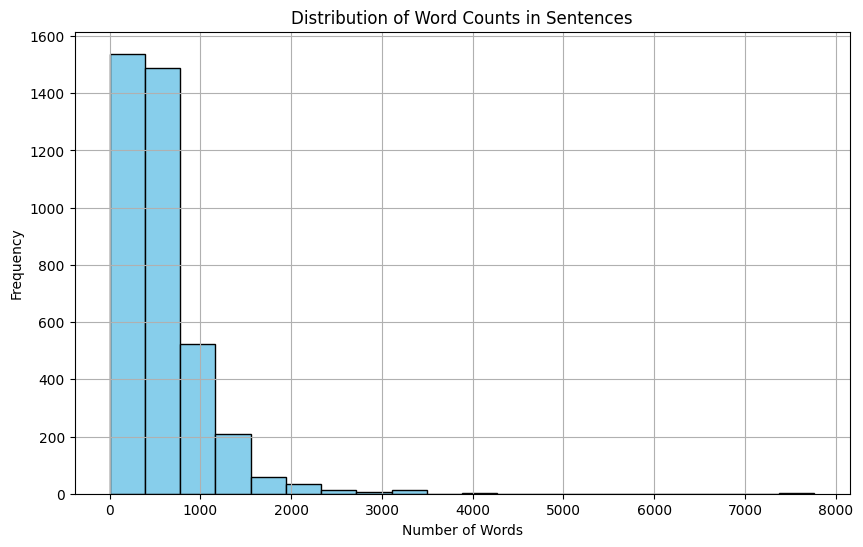

In [ ]:
train_df['withoutStopword'] = train_df.cleaned.map(remove_stopword)
train_df['pre_word_count'] = train_df['withoutStopword'].apply(lambda x: len(re.findall(r'\b\w+\b', str(x))))
plt.figure(figsize=(10, 6))
plt.hist(train_df['pre_word_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts in Sentences')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
max_word_count_index = train_df['pre_word_count'].idxmax()
max_word_count_sentence = train_df.loc[max_word_count_index, 'summary']

print(f"\nSentence with Maximum Word Count (words={train_df['pre_word_count'].max()})")

print(f"\nAverage Number of Words: {train_df['pre_word_count'].mean():.2f}")


Sentence with Maximum Word Count (words=7765)

Average Number of Words: 554.73


In [ ]:
sum(train_df.pre_word_count)

2155674

##Removing most frequent 10 words

In [ ]:
dt = train_df.withoutStopword.to_list()
corpas = " ".join(dt)
print(len(corpas))

from collections import Counter
p = Counter(corpas.split()).most_common(10)
rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])
print(rslt)

5456667
      Word  Frequency
0       এক       7762
1     সাথে       5105
2     লেখক       4714
3       বই       4550
4      কথা       3506
5     বইটি       3372
6     পড়ে       3095
7  উপন্যাস       2659
8     একজন       2634
9     ভালো       2579


In [ ]:
rslt.to_csv('most_frequent_word_in_corpas.csv', index=False)

In [ ]:
rslt = pd.read_csv('most_frequent_word_in_corpas.csv')

In [ ]:
mfw = rslt.Word.to_list()

In [ ]:
def del_mfw(text):
  tokened_words = bl_tokenizer.word_tokenizer(text)
  new_words = []
  for i in tokened_words:
      if i in mfw:
          del i
      else:
          new_words.append(i)
  return " ".join(new_words)

In [ ]:
train_df['withoutMF'] = train_df.withoutStopword.map(del_mfw)
train_df['wmf_word_count'] = train_df['withoutMF'].apply(lambda x: len(re.findall(r'\b\w+\b', str(x))))

print(f"\nSentence with Maximum Word Count (words={train_df['wmf_word_count'].max()})")

print(f"\nAverage Number of Words: {train_df['wmf_word_count'].mean():.2f}")


Sentence with Maximum Word Count (words=7627)

Average Number of Words: 542.39


In [ ]:
(train_df.wmf_word_count == 0).value_counts()

False    3868
Name: wmf_word_count, dtype: int64

In [ ]:
train_df[(train_df.wmf_word_count == 0)].index

Int64Index([], dtype='int64')

In [ ]:
train_df.drop(train_df[(train_df.wmf_word_count == 0)].index, inplace=True)

In [ ]:
train_df.to_csv('mfw_preprocessed.csv', index=False)

In [ ]:
train_df = pd.read_csv('mfw_preprocessed.csv')

# Fine-Tuning `csebuetnlp/banglabert`

In [ ]:
train, test = train_test_split(train_df, test_size=0.10, random_state=1804109)
len(train), len(test)

(3481, 387)

In [ ]:
train.head()

,summary,genre,Label,word_count,cleaned,withoutStopword,pre_word_count,withoutMF,wmf_word_count
238,শঙ্কু সমগ্র লেখক –সত্যজিৎ রায় প্রকাশনী – আনন্দ...,Science-Fiction,4,560,শঙ্কু সমগ্র লেখক সত্যজিৎ রায় প্রকাশনী আনন্...,শঙ্কু সমগ্র লেখক সত্যজিৎ রায় প্রকাশনী আনন্দ প...,422,শঙ্কু সমগ্র সত্যজিৎ রায় প্রকাশনী আনন্দ পাবলিশ...,416
1600,এটা আমার এযাবত পড়া সাইকো থৃলারগুলোর মধ্যে শ্র...,Thriller,1,580,এটা আমার এযাবত পড়া সাইকো থৃলারগুলোর মধ্যে শ্র...,এযাবত পড়া সাইকো থৃলারগুলোর শ্রেষ্ঠ বই একথা চো...,467,এযাবত পড়া সাইকো থৃলারগুলোর শ্রেষ্ঠ একথা চোখ ব...,459
2044,#রকমারি_বইপোকা_রিভিউ_প্রতিযোগিতা\r\n\r\n|| রিভ...,Fiction,0,1199,রিভিউ বই জেনারেল ও নারীরা লেখক আনিসুল...,রিভিউ বই জেনারেল নারীরা লেখক আনিসুল হক প্রকাশক...,968,রিভিউ জেনারেল নারীরা আনিসুল হক প্রকাশক প্রথমা ...,941
357,রিভিউ-ব্ল্যাকহোলের বাচ্চা আজ রাত সোয়া নয়টার দি...,Childrens-Book,2,868,রিভিউ ব্ল্যাকহোলের বাচ্চা আজ রাত সোয়া নয়টার ...,রিভিউ ব্ল্যাকহোলের বাচ্চা রাত সোয়া নয়টার পড়...,647,রিভিউ ব্ল্যাকহোলের বাচ্চা রাত সোয়া নয়টার পড়...,619
246,বই সর্ম্পকে মতামতঃ \r\nবইয়ের নামঃ দারবিশ।\r\nল...,Fiction,0,1182,বই সর্ম্পকে মতামত বইয়ের নাম দারবিশ লেখক ল...,বই সর্ম্পকে মতামত বইয়ের নাম দারবিশ লেখক লতিফু...,904,সর্ম্পকে মতামত বইয়ের নাম দারবিশ লতিফুল ইসলাম ...,868


In [ ]:
dtrain = train[['withoutMF', 'Label']]
dval = test[['withoutMF', 'Label']]
dtrain.head()

,withoutMF,Label
238,শঙ্কু সমগ্র সত্যজিৎ রায় প্রকাশনী আনন্দ পাবলিশ...,4
1600,এযাবত পড়া সাইকো থৃলারগুলোর শ্রেষ্ঠ একথা চোখ ব...,1
2044,রিভিউ জেনারেল নারীরা আনিসুল হক প্রকাশক প্রথমা ...,0
357,রিভিউ ব্ল্যাকহোলের বাচ্চা রাত সোয়া নয়টার পড়...,2
246,সর্ম্পকে মতামত বইয়ের নাম দারবিশ লতিফুল ইসলাম ...,0


In [ ]:
dtrain.withoutMF.isna().value_counts()

False    3481
Name: withoutMF, dtype: int64

In [ ]:
train_ds = Dataset.from_pandas(dtrain, preserve_index=False)
eval_ds = Dataset.from_pandas(dval, preserve_index=False)
train_ds

Dataset({
    features: ['withoutMF', 'Label'],
    num_rows: 3481
})

In [ ]:
checkpoint = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["withoutMF"], truncation=True, max_length=512)


tokenized_datasets = train_ds.map(tokenize_function, batched=True)
tokenized_val_datasets = eval_ds.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Map:   0%|          | 0/387 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_datasets = tokenized_datasets.remove_columns(["withoutMF"])
tokenized_train_datasets = tokenized_train_datasets.rename_column("Label", "labels")
tokenized_train_datasets.set_format("torch")
print(tokenized_train_datasets.column_names)

tokenized_eval_datasets = tokenized_val_datasets.remove_columns(["withoutMF"])
tokenized_eval_datasets = tokenized_eval_datasets.rename_column("Label", "labels")
tokenized_eval_datasets.set_format("torch")
print(tokenized_eval_datasets.column_names)

['labels', 'input_ids', 'token_type_ids', 'attention_mask']
['labels', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Use a API Access token for saving the model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
training_args = TrainingArguments("test-trainer-withoutMF-0-2",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=5,
                                  learning_rate = 6e-5,
                                  weight_decay = 5e-7,
                                  save_total_limit=2,
                                  metric_for_best_model="eval_loss",
                                  greater_is_better=False,
                                  push_to_hub=True,
                                  optim='adafactor'
                                  )

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=7)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_eval_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.603200,0.801034,0.794855,0.757138,0.759103
2,0.912500,0.496840,0.842377,0.836014,0.836475,0.832637
3,0.440500,0.577821,0.865633,0.855063,0.824437,0.837372
4,0.308700,0.558483,0.875969,0.870957,0.863573,0.864062
5,0.206200,0.551689,0.883721,0.868274,0.854708,0.860728


TrainOutput(global_step=2180, training_loss=0.44248799140300227, metrics={'train_runtime': 1695.2787, 'train_samples_per_second': 10.267, 'train_steps_per_second': 1.286, 'total_flos': 4101014507352600.0, 'train_loss': 0.44248799140300227, 'epoch': 5.0})

#Inference

In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Id,summary
0,0,আমার কোন উপন্যাস তখনি ভাল লাগে যখন আমি এর চরিত...
1,1,বইঃ দ্য সান অফ লাইট (রামেসিস #1) লেখকঃ ক্রিশ্চ...
2,2,বাংলাদেশ আমার জন্মভূমি। সাতপুরুষের ভিটে-মাটি। ...
3,3,বিংশ শতাব্দীর বাঙালি জনপ্রিয় কথাসাহিত্যিকদের ...
4,4,অনেক সুন্দর এবং অসাধারণ একটি বই.... মধ্যবিত্ত...


## Preprocessing the test set before prediction

In [ ]:
test_df['cleaned'] = test_df.summary.map(preprocessing)
test_df['withoutStopword'] = test_df.cleaned.map(remove_stopword)

In [ ]:
test_df.head()

,Id,summary,cleaned,withoutStopword
0,0,আমার কোন উপন্যাস তখনি ভাল লাগে যখন আমি এর চরিত...,আমার কোন উপন্যাস তখনি ভাল লাগে যখন আমি এর চরিত...,উপন্যাস তখনি ভাল লাগে চরিত্র গুলো বুঝতে চরিত্র...
1,1,বইঃ দ্য সান অফ লাইট (রামেসিস #1) লেখকঃ ক্রিশ্চ...,বই দ্য সান অফ লাইট রামেসিস লেখক ক্রিশ্চিয...,বই দ্য সান অফ লাইট রামেসিস লেখক ক্রিশ্চিয়ান জ...
2,2,বাংলাদেশ আমার জন্মভূমি। সাতপুরুষের ভিটে-মাটি। ...,বাংলাদেশ আমার জন্মভূমি সাতপুরুষের ভিটে মাটি ...,বাংলাদেশ জন্মভূমি সাতপুরুষের ভিটে মাটি আজও জীব...
3,3,বিংশ শতাব্দীর বাঙালি জনপ্রিয় কথাসাহিত্যিকদের ...,বিংশ শতাব্দীর বাঙালি জনপ্রিয় কথাসাহিত্যিকদের ...,বিংশ শতাব্দীর বাঙালি জনপ্রিয় কথাসাহিত্যিকদের ...
4,4,অনেক সুন্দর এবং অসাধারণ একটি বই.... মধ্যবিত্ত...,অনেক সুন্দর এবং অসাধারণ একটি বই মধ্যবিত্ত পরি...,সুন্দর অসাধারণ বই মধ্যবিত্ত পরিবারের সুখ খ আনন...


In [ ]:
test_df.set_index('Id', inplace=True)
test_df

,summary,cleaned,withoutStopword
Id,,,
0,আমার কোন উপন্যাস তখনি ভাল লাগে যখন আমি এর চরিত...,আমার কোন উপন্যাস তখনি ভাল লাগে যখন আমি এর চরিত...,উপন্যাস তখনি ভাল লাগে চরিত্র গুলো বুঝতে চরিত্র...
1,বইঃ দ্য সান অফ লাইট (রামেসিস #1) লেখকঃ ক্রিশ্চ...,বই দ্য সান অফ লাইট রামেসিস লেখক ক্রিশ্চিয...,বই দ্য সান অফ লাইট রামেসিস লেখক ক্রিশ্চিয়ান জ...
2,বাংলাদেশ আমার জন্মভূমি। সাতপুরুষের ভিটে-মাটি। ...,বাংলাদেশ আমার জন্মভূমি সাতপুরুষের ভিটে মাটি ...,বাংলাদেশ জন্মভূমি সাতপুরুষের ভিটে মাটি আজও জীব...
3,বিংশ শতাব্দীর বাঙালি জনপ্রিয় কথাসাহিত্যিকদের ...,বিংশ শতাব্দীর বাঙালি জনপ্রিয় কথাসাহিত্যিকদের ...,বিংশ শতাব্দীর বাঙালি জনপ্রিয় কথাসাহিত্যিকদের ...
4,অনেক সুন্দর এবং অসাধারণ একটি বই.... মধ্যবিত্ত...,অনেক সুন্দর এবং অসাধারণ একটি বই মধ্যবিত্ত পরি...,সুন্দর অসাধারণ বই মধ্যবিত্ত পরিবারের সুখ খ আনন...
...,...,...,...
682,বইটির কাহিনী আবর্তিত হয়েছে যুক্তরাষ্ট্রের দুই ...,বইটির কাহিনী আবর্তিত হয়েছে যুক্তরাষ্ট্রের দুই...,বইটির কাহিনী আবর্তিত যুক্তরাষ্ট্রের প্রধান রাজ...
683,"ফরাসি বিপ্লব মানে বুর্জোয়া বিপ্লব, আদি সমাজতা...",ফরাসি বিপ্লব মানে বুর্জোয়া বিপ্লব আদি সমাজতা...,ফরাসি বিপ্লব মানে বুর্জোয়া বিপ্লব আদি সমাজতান...
684,শুভ্র চরিত্রটি আমরা প্রথম দেখতে পাই ‘দারুচিনি...,শুভ্র চরিত্রটি আমরা প্রথম দেখতে পাই দারুচিনি দ...,শুভ্র চরিত্রটি পাই দারুচিনি দ্বীপ উপন্যাসের শু...


In [ ]:
test_df['withourMfw'] = test_df.withoutStopword.map(del_mfw)

In [ ]:
checkpoint = "Udoy/test-trainer-withoutMF-0-2"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["withourMfw"], truncation=True, max_length=512)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

##Generating Predictions

In [ ]:
import torch
preds = []
for row in test_df.iterrows():
  text = row[1]['withourMfw']
  tokenized_text = tokenizer(text,
                             return_tensors="pt",
                             padding=True,
                             truncation=True,
                             max_length=512)
  with torch.no_grad():
    pred = model(**tokenized_text)
  logits = pred.logits
  predicted_class = torch.argmax(logits, dim=1).item()
  preds.append(predicted_class)

In [ ]:
len(preds)

687

In [ ]:
test_df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            677, 678, 679, 680, 681, 682, 683, 684, 685, 686],
           dtype='int64', name='Id', length=687)

In [ ]:
submission = pd.DataFrame()
submission['Id'] = test_df.index
submission['Label'] = preds

In [ ]:
submission.head()

,Id,Label
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0


In [ ]:
submission.to_csv('second_last_submission.csv', index=False)